## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as npy
import nltk

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Load dataset

In [3]:
df = pd.read_csv('emails.txt', delimiter='\t', header=None)
df.columns = ['category', 'content']

In [4]:
df.shape

(5572, 2)

In [5]:
total_emails = df.shape[0]

In [6]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [7]:
# df.iat[0,1]

### Preprocess data

In [8]:
from nltk.tokenize import sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import punctuation as pun
lem = WordNetLemmatizer()

In [9]:
def preprocess(email_content):
    new_content = []
    for content_word in email_content.lower().split():                #spliting all words of the email string
        for word in sent_tokenize(content_word):               #tokenizing the word further
            word = word.translate(str.maketrans('', '', pun))  #removing punctuations
            word = lem.lemmatize(word)                         #lemmatization to get word lemma
            if word not in stop_words:
                new_content.append(word)
    return ' '.join(new_content)

In [10]:
df['content'] = df['content'].apply(lambda x: preprocess(x))

In [11]:
# df['category'].value_counts()

### Split data

In [12]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.20, random_state=2)

In [13]:
# train_df

TF-IDF_Vectorization

In [14]:
count_vector = []      
doc_word_cnt = dict()   # word appers in how many emails

In [15]:
for ind, row in train_df.iterrows():
    vector = dict()
    word_cnt = 0
    for word in row['content'].split():                #spliting all words of the email string
        vector[word] = vector.get(word, 0) + 1
        word_cnt += 1
        if vector[word] == 1:
            doc_word_cnt[word] = doc_word_cnt.get(word, 0) + 1
    if vector:
        count_vector.append(((vector, word_cnt), 1 if row['category'] == 'spam' else 0))

In [16]:
from math import log, sqrt
N = len(count_vector)

In [17]:
for value in count_vector:
    word_cnt = value[0][1]
    vector = value[0][0]
    for word in vector.keys():
        vector[word] = (vector[word]/word_cnt)*(log((N+1)/(doc_word_cnt.get(word, 0)+1))+1)

### Train your KNN model (reuse previously iplemented model built from scratch) and test on your data

In [18]:
from heapq import heapify, heappush, heappop

In [19]:
def cosine_distance(v1, v2):
    v1_sum = sum([a**2 for a in v1.values()])
    v2_sum = 0
    dot_product = 0
    for word in v2.keys():
        if word in v1:
            dot_product += v1[word]*v2[word]
        v2_sum += v2[word]**2
    return 1 - dot_product/(sqrt(v1_sum * v2_sum))

In [20]:
def euclidean(v1, v2):
    value = 0
    for word in v2.keys():
        if word in v1:
            value += (v1[word] - v2[word])**2
        else:
            value += (v2[word])**2
    for word in v1.keys():
        if word not in v2:
            value += (v1[word])**2
    return sqrt(value)

In [21]:
def manhattan(v1, v2):
    value = 0
    for word in v2.keys():
        if word in v1:
            value += abs(v1[word] - v2[word])
        else:
            value += (v2[word])
    for word in v1.keys():
        if word not in v2:
            value += (v1[word])
    return value

In [22]:
def hamming(v1, v2):
    return manhattan(v1, v2)/(max(len(v1), len(v2)))

In [23]:
def distance(v1, v2, metric_name):
    if metric_name == 'cosine':
        return cosine_distance(v1, v2)
    if metric_name == 'hamming':
        return hamming(v1, v2)
    if metric_name == 'manhattan':
        return manhattan(v1, v2)
    if metric_name == 'euclidean':
        return euclidean(v1, v2)

In [24]:
def classification(vector, k, metric):
    max_heap = []
    heapify(max_heap)
    for value in count_vector:
        category = value[1]
        vector_train = value[0][0]
        if vector_train and vector:
            heappush(max_heap, (-distance(vector_train, vector, metric), category))
            if len(max_heap) > k:
                heappop(max_heap)
    
    majority = [0,0]
    for value in max_heap:
        majority[value[1]] += 1
    
    return 1 if majority[1] > majority[0] else 0

In [25]:
def measure_accuracy(pred, act):
    correct, wrong = 0, 0
    for i, j in zip(pred, act):
        if i == j:
            correct += 1
        else:
            wrong += 1
    return (correct/(correct+wrong))

In [26]:
# test_df['category']

In [27]:
act = [1 if row == 'spam' else 0 for row in test_df['category']]

In [28]:
def test_model(k=11, metric ='cosine'):
    pred = [0 for _ in range(test_df.shape[0])]
    i = 0
    for row in test_df['content']:
        vector = dict()
        word_cnt = 1
        for word in row.split():
            vector[word] = vector.get(word, 0) + 1
            word_cnt += 1
        for word in vector.keys():
            vector[word] = (vector[word]/word_cnt)*(log(N/(1+doc_word_cnt.get(word, 0))))

        pred[i] = classification(vector, k, metric)
        i += 1
        
    return pred

In [29]:
# pred = test_model()

In [30]:
import matplotlib.pyplot as plt

In [31]:
# print(pred)

In [32]:
# print(act)

In [33]:
# measure_accuracy(pred, act)

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [34]:
def cal_confusion_matrix(pred):
    true_neg, true_pos, false_pos, false_neg = 0, 0, 0, 0
    for i, j in zip(pred, act):
        if i == j:
            if i == 0:
                true_neg += 1
            else:
                true_pos += 1
        else:
            if j == 0:
                false_pos += 1
            else:
                false_neg += 1
    return {'true_neg':true_neg, 'false_neg': false_neg, 'false_pos':false_pos, 'true_pos':true_pos}

In [35]:
def cal_precision(confusion_matrix):
    return confusion_matrix['true_pos']/(confusion_matrix['true_pos'] + confusion_matrix['false_pos'])

In [36]:
def cal_recall(confusion_matrix):
    return confusion_matrix['true_pos']/(confusion_matrix['true_pos'] + confusion_matrix['false_neg'])

In [37]:
def cal_f1score(precision, recall):
    return (2*precision*recall)/(precision+recall)

In [38]:
metrics = ['euclidean', 'cosine', 'manhattan', 'hamming']
accuracy_metrics = []
f1_metrics = []
cosine_results = []

In [39]:
for metric in metrics:
    pred = test_model(metric=metric)
#     print(metric,'Accuracy -', measure_accuracy(pred, act))
    accuracy_metrics.append(measure_accuracy(pred, act))
    confusion_matrix = cal_confusion_matrix(pred)
    precision = cal_precision(confusion_matrix)
    recall = cal_recall(confusion_matrix)
    f1_score = cal_f1score(precision, recall)
    f1_metrics.append(f1_score)
    if metric == 'cosine':
        cosine_results.extend([accuracy_metrics[-1], confusion_matrix, precision, recall, f1_score])

In [40]:
display_readings = pd.DataFrame(columns=['Metrics', 'Accuracies'])
display_readings['Metrics'] = metrics
display_readings['Accuracies'] = accuracy_metrics
display_readings

,Metrics,Accuracies
0,euclidean,0.888789
1,cosine,0.939013
2,manhattan,0.898655
3,hamming,0.860090


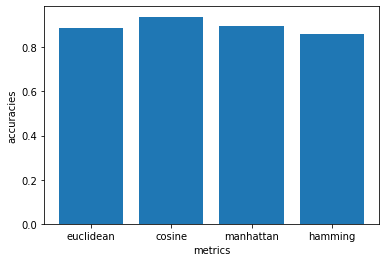

In [41]:
plt.bar(metrics, accuracy_metrics)
plt.xlabel('metrics')
plt.ylabel('accuracies')
plt.show()

In [42]:
display_readings = pd.DataFrame(columns=['Metrics', 'F1-Score'])
display_readings['Metrics'] = metrics
display_readings['F1-Score'] = f1_metrics
display_readings

,Metrics,F1-Score
0,euclidean,0.380000
1,cosine,0.755396
2,manhattan,0.443350
3,hamming,0.025000


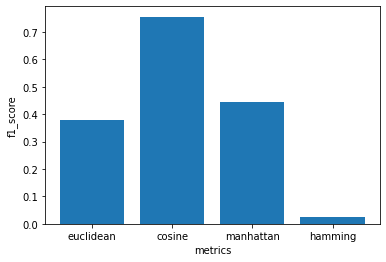

In [43]:
plt.bar(metrics, f1_metrics)
plt.xlabel('metrics')
plt.ylabel('f1_score')
plt.show()

***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

***Calculate Confusion matrix, Precision, Recall, and F1 Score***

-Accuracy may not be a good measure if the dataset is not balanced (both negative and positive classes have different number of data instances). Using accuracy in such scenarios can result in misleading interpretation of results.

-Precision should ideally be 1 (high) for a good classifier. Precision becomes 1 only when the numerator and denominator are equal i.e TP = TP +FP, this also means FP is zero. As FP increases the value of denominator, it becomes greater than the numerator and precision value decreases (which we don’t want).

-Recall is also known as sensitivity or true positive rate and is defined as TP/(TP + FN).

-So ideally in a good classifier, we want both precision and recall to be one which also means FP and FN are zero. Therefore we need a metric that takes into account both precision and recall. 

-F1-score is a metric which takes into account both precision and recall and is defined as 2*(Precision*Recall)/(Precision+Recall). F1 score is the harmonic mean of precision and recall and is a better measure than accuracy.

In [44]:
print('Confusion Matrix')
print(cosine_results[1])

Confusion Matrix
{'true_neg': 942, 'false_neg': 53, 'false_pos': 15, 'true_pos': 105}


In [45]:
print('Accuracy - ', cosine_results[0])

Accuracy -  0.9390134529147982


In [46]:
print('Precision - ', cosine_results[2])

Precision -  0.875


In [47]:
print('Recall - ', cosine_results[3])

Recall -  0.6645569620253164


In [48]:
print('F1-Score - ', cosine_results[4])

F1-Score -  0.7553956834532374


***Plot for different values of "K" VS F1-score***

In [49]:
diff_k = [1,3,5,7,11,17,23,27]
diff_f1 = []

In [50]:
for k in diff_k:
    pred = test_model(k=k, metric='cosine')
    confusion_matrix = cal_confusion_matrix(pred)
    precision = cal_precision(confusion_matrix)
    recall = cal_recall(confusion_matrix)
    f1_score = cal_f1score(precision, recall)
    diff_f1.append(f1_score)

In [51]:
display_readings = pd.DataFrame(columns=['K', 'F1-Score'])
display_readings['K'] = diff_k
display_readings['F1-Score'] = diff_f1
display_readings

,K,F1-Score
0,1,0.853147
1,3,0.828571
2,5,0.785455
3,7,0.751825
4,11,0.755396
5,17,0.705036
6,23,0.685714
7,27,0.664286


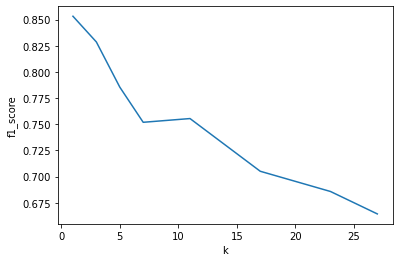

In [52]:
plt.xlabel('k')
plt.ylabel('f1_score')
plt.plot(diff_k, diff_f1)
plt.show()

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

In [53]:
# best_metric

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

In [55]:
count_vect = CountVectorizer()
tfidfconverter = TfidfTransformer()
knn = KNeighborsClassifier(n_neighbors=7, metric='cosine')

In [56]:
emails_test = test_df['content']
category_test = test_df['category']
emails_train = train_df['content']
category_train = train_df['category']

In [57]:
email_train_counts = count_vect.fit_transform(emails_train)

In [58]:
email_train_tfidf = tfidfconverter.fit_transform(email_train_counts)

In [59]:
classification = knn.fit(email_train_tfidf, category_train)

In [60]:
email_test_counts = count_vect.transform(emails_test)
email_test_tfidf = tfidfconverter.transform(email_test_counts)
predicted = classification.predict(email_test_tfidf)


In [61]:
# npy.mean(predicted == category_test)

In [62]:
conf_matrix = confusion_matrix(category_test,predicted)
accuracy = accuracy_score(category_test, predicted)

In [63]:
print(conf_matrix)
print(accuracy)

[[955   2]
 [ 55 103]]
0.9488789237668162


In [64]:
conf_matrix_dic = {
    'true_neg':conf_matrix[0,0],
    'false_neg':conf_matrix[1,0],
    'false_pos':conf_matrix[0,1],
    'true_pos':conf_matrix[1,1],
}
# print(conf_matrix_dic)
# print((conf_matrix_dic['true_neg']+conf_matrix_dic['true_pos'])/sum(conf_matrix_dic.values()))

***Compare both the models result.***

In [65]:
comparison = pd.DataFrame(columns = ['Scratch Model', "SkLearn's"])


In [66]:
list(precision_recall_fscore_support(category_test, predicted, average='micro')[:-1])

[0.9488789237668162, 0.9488789237668162, 0.9488789237668162]

In [67]:
[accuracy].extend([1])

In [68]:
comparison['Scratch Model'] = [cosine_results[0]] + cosine_results[2:]
sklearn_l = [accuracy]
sklearn_l.extend(precision_recall_fscore_support(category_test, predicted, average='weighted')[:-1])
comparison['SkLearn\'s'] = sklearn_l
comparison.index =  ['accuracy', 'precision', 'recall', 'f1_score']
comparison

,Scratch Model,SkLearn's
accuracy,0.939013,0.948879
precision,0.875000,0.950562
recall,0.664557,0.948879
f1_score,0.755396,0.944417


***What is the time complexity of training using KNN classifier?***

O(nd), where n is size of training data set and d is distance metric time

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***